# Evaluation of the different trained models in terms of losses

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib2tikz as plt2tikz
from skimage.feature import peak_local_max

## Selection of the best models encountered through training (based on test loss)

Dataset for training and validation, __10 images with 1250 cells__. __7__ images for __training__, __3__ for __testing__. Batches of only one image. Therefore, reported train loss is on one (random) training image, while the reported test loss is the average of the three test images.

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


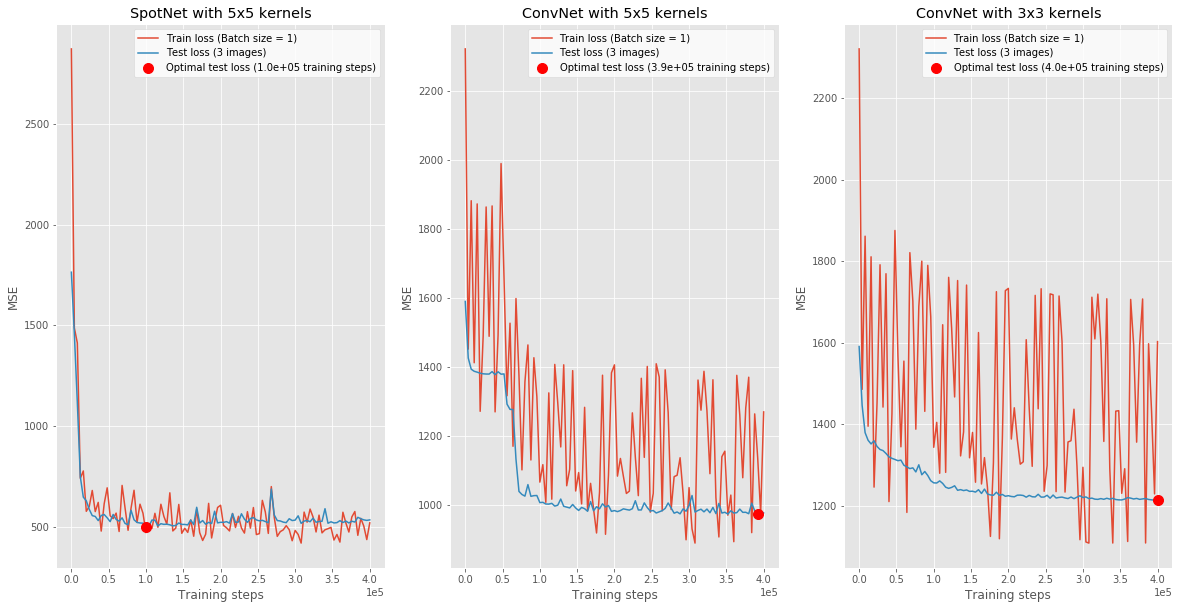

In [2]:
# Load data for SpotNet with 5x5 kernels
results_dir = 'spotnet_results/'
spotnet_5_results = np.loadtxt( results_dir + 'trained_spotnet_history_5_kersize.txt' )
spotnet_5_iterations_record = spotnet_5_results[:,0] 
spotnet_5_train_loss_record = spotnet_5_results[:,1] 
spotnet_5_test_loss_record =  spotnet_5_results[:,2]
# Load data for ConvNet with 5x5 kernels
convnet_5_results = np.loadtxt( results_dir + 'trained_convnet_history_5_kersize.txt' )
convnet_5_iterations_record = convnet_5_results[:,0] 
convnet_5_train_loss_record = convnet_5_results[:,1] 
convnet_5_test_loss_record =  convnet_5_results[:,2]
# Load data for ConvNet with 3x3 kernels
convnet_3_results = np.load( results_dir + 'trained_convnet_history_train-steps_3_kersize.npz' )
convnet_3_iterations_record = convnet_3_results['iterations_record']
convnet_3_train_loss_record = convnet_3_results['train_loss_record']
convnet_3_test_loss_record  = convnet_3_results[ 'test_loss_record']

# Visualize losses vs iterations and picks of optimals
plt.figure( figsize = [20,10] );
plt.style.use("ggplot")
plt.grid(True)

# First subplot, SpotNet with 5x5 kernels
plt.subplot( 131 )
# Plot curves
plt.plot( spotnet_5_iterations_record, spotnet_5_train_loss_record,
          spotnet_5_iterations_record, spotnet_5_test_loss_record )
# Find optimal and plot it
spotnet_5_optimal = spotnet_5_test_loss_record.argmin( )
plt.plot( spotnet_5_iterations_record[spotnet_5_optimal], 
          spotnet_5_test_loss_record[ spotnet_5_optimal],
          'ro', markersize = 10 )
# Legend
plt.legend( ( 'Train loss (Batch size = 1)', 'Test loss (3 images)', 
              'Optimal test loss (%.1e training steps)'%spotnet_5_iterations_record[spotnet_5_optimal] ),
            facecolor = 'white' )
# Axis labels
plt.xlabel( 'Training steps' )
plt.ylabel( 'MSE' )
# Title and scientific format for iterations
plt.title( 'SpotNet with 5x5 kernels' )
plt.ticklabel_format( style = 'sci', axis = 'x', scilimits = (0, 0) )

# Second subplot, ConvNet with 5x5 kernels
plt.subplot( 132 )
# Plot curves
plt.plot( convnet_5_iterations_record, convnet_5_train_loss_record,
          convnet_5_iterations_record, convnet_5_test_loss_record )
# Find optimal and plot it
convnet_5_optimal = convnet_5_test_loss_record.argmin( )
plt.plot( convnet_5_iterations_record[convnet_5_optimal], 
          convnet_5_test_loss_record[ convnet_5_optimal],
          'ro', markersize = 10 )
# Legend
plt.legend( ( 'Train loss (Batch size = 1)', 'Test loss (3 images)', 
              'Optimal test loss (%.1e training steps)'%convnet_5_iterations_record[convnet_5_optimal] ),
            facecolor = 'white' )
# Axis labels
plt.xlabel( 'Training steps' )
plt.ylabel( 'MSE' )
# Title and scientific format for iterations
plt.title( 'ConvNet with 5x5 kernels' )
plt.ticklabel_format( style = 'sci', axis = 'x', scilimits = (0, 0) )


# Third subplot, ConvNet with 3x3 kernels
plt.subplot( 133 )
# Plot curves
plt.plot( convnet_3_iterations_record, convnet_3_train_loss_record,
          convnet_3_iterations_record, convnet_3_test_loss_record )
# Find optimal and plot it
convnet_3_optimal = convnet_3_test_loss_record.argmin( )
plt.plot( convnet_3_iterations_record[convnet_3_optimal], 
          convnet_3_test_loss_record[ convnet_3_optimal],
          'ro', markersize = 10 )
# Legend
plt.legend( ( 'Train loss (Batch size = 1)', 'Test loss (3 images)', 
              'Optimal test loss (%.1e training steps)'%convnet_3_iterations_record[convnet_3_optimal] ),
            facecolor = 'white' )
# Axis labels
plt.xlabel( 'Training steps' )
plt.ylabel( 'MSE' )
# Title and scientific format for iterations
plt.title( 'ConvNet with 3x3 kernels' )
plt.ticklabel_format( style = 'sci', axis = 'x', scilimits = (0, 0) )

plt2tikz.save('../../paper/figs/convergence_networks.tex');

## Loading of the best models encountered through training

In [3]:
spotnet_5_predict = tf.contrib.predictor.from_saved_model( results_dir + 
                                                          'trained_spotnet_%d_train-steps_5_kersize/'%(
                                                          spotnet_5_iterations_record[spotnet_5_optimal] ) )
convnet_5_predict = tf.contrib.predictor.from_saved_model( results_dir + 
                                                          'trained_convnet_%d_train-steps_5_kersize/'%(
                                                          convnet_5_iterations_record[convnet_5_optimal] ) )
convnet_3_predict = tf.contrib.predictor.from_saved_model( results_dir + 
                                                          'trained_convnet_%d_train-steps_3_kersize/'%(
                                                          convnet_3_iterations_record[convnet_3_optimal] ) )
predicts_for_eval = [spotnet_5_predict, convnet_5_predict, convnet_3_predict]

INFO:tensorflow:Restoring parameters from spotnet_results/trained_spotnet_100000_train-steps_5_kersize/variables/variables
INFO:tensorflow:Restoring parameters from spotnet_results/trained_convnet_392000_train-steps_5_kersize/variables/variables
INFO:tensorflow:Restoring parameters from spotnet_results/trained_convnet_400000_train-steps_3_kersize/variables/variables


# Evaluation of the different trained models in terms of detection metrics
## Calculate of the F1-score in a set of weighted detections

The standard for the journal papers to measure performance was much more relaxed that straight-up F1 score with a pre-determined threshold. In fact, one would detect local maxima in the image first, and then proceed to find the threshold level that led to the higher possible F1 score. The smart way to do this is to sort detections (local maxima) by "pseudo_likelihood" (mean_estimated_psdrs) value and see how the F1 score changes as we include more and more detections with lower pseudo_likelihood.

Also, it is really important to exclude already-matched target points, or otherwise many different estimated detections could be matched to the same true one. 

In [4]:
# For a pseudo_likelihood image, find local maxima and then get optimal thresholding for 
# their consideration as detections in terms of F1-Score
def optimal_f1_score( pseudo_likelihood, x_target, y_target, tolerance = 3, verbose = 1 ):
    # Find local maxima in image [look at neighborhood!!]
    pos = peak_local_max( pseudo_likelihood )
    x_output = pos[:,0]; y_output = pos[:,1]
    # Extract and sort pseudo-likelihoods (decreasing)
    pseudo_likelihood = pseudo_likelihood[x_output, y_output]
    p_l_order = np.flip( np.argsort( pseudo_likelihood ), axis = 0 )
    pseudo_likelihood = pseudo_likelihood[ p_l_order ]
    # Sort detections similarly
    x_output = x_output[ p_l_order ]
    y_output = y_output[ p_l_order ]
    # Initialize variables to keep track of matching process
    correct_flag = np.zeros( p_l_order.shape )
    target_taken_by = np.empty( x_target.shape ); target_taken_by[:] = np.nan;
    # Matching process
    for index in range( p_l_order.size ):
        # Compute distances to ground truth from the index-th detection
        squared_distances = ( x_output[index] - x_target )**2 + ( y_output[index] - y_target )**2
        # Make sure no previosly selected target point is picked again
        squared_distances[~np.isnan(target_taken_by)] = squared_distances.max()+1
        # Get candidate target for index-th detection
        candidate_index = squared_distances.argmin()
        # Take decision and store results
        if np.sqrt( squared_distances[candidate_index] ) <= tolerance:
            correct_flag[index] = 1
            target_taken_by[candidate_index] = index
        
    # Compute metrics at alll possible thresholding levels
    true_positives  = np.cumsum( correct_flag )
    false_positives = np.arange( 1, p_l_order.size + 1 ) - true_positives
    false_negatives = x_target.size - true_positives
    precision = true_positives / (true_positives + false_positives + np.finfo( np.float32 ).eps )
    recall    = true_positives / (true_positives + false_negatives + np.finfo( np.float32 ).eps )
    f1_score  = 2 * precision * recall / (precision + recall + np.finfo( np.float32 ).eps )
    # Get the best thresholding in terms of F1-Score
    best_cutpoint = f1_score.argmax()
    # Inform user
    if verbose == 2:
        print( "TP: %d, FP: %d, FN: %d, prec: %0.4f, rec: %0.4f, F1: %0.4f, threshold: %4.4f"%(
                true_positives[best_cutpoint], false_positives[best_cutpoint],
                false_negatives[best_cutpoint], precision[best_cutpoint],
                recall[best_cutpoint], f1_score[best_cutpoint], 
                .5*( pseudo_likelihood[best_cutpoint] + pseudo_likelihood[best_cutpoint+1] ) ) )
    elif verbose == 1:
        print( "%0.4f"%( f1_score[best_cutpoint] ), end = ' ' )
    
    return ( f1_score[best_cutpoint], x_output[:best_cutpoint], y_output[:best_cutpoint], correct_flag[:best_cutpoint] )

# For a simple list of detections without pseudo-likelihoods, compute F1-Score
def simple_f1_score( x_estimated, y_estimated, x_target, y_target, tolerance = 3, verbose = 1 ):
    # Initialize variables to keep track of matching process
    correct_flag = np.zeros( x_estimated.shape )
    # Matching process
    for index in range( x_target.size ):
        # Compute distances to detections from the index-th ground truth point
        squared_distances = (x_target[index] - x_estimated)**2 + (y_target[index] - y_estimated)**2
        # Make sure no previously selected estimated point is picked again
        squared_distances[correct_flag>0] = squared_distances.max()+1
        # Get candidate estimated point of index-th ground truth
        candidate_index = squared_distances.argmin()
        # Take decision and store results
        if np.sqrt( squared_distances[candidate_index] ) <= tolerance:
            correct_flag[candidate_index] = 1
    
    # Compute metrics
    true_positives  = np.sum( correct_flag )
    false_positives = x_estimated.size - true_positives
    false_negatives = x_target.size - true_positives
    precision = true_positives / (true_positives + false_positives + np.finfo( np.float32 ).eps )
    recall    = true_positives / (true_positives + false_negatives + np.finfo( np.float32 ).eps )
    f1_score  = 2 * precision * recall / (precision + recall + np.finfo( np.float32 ).eps )
    # Inform user
    if verbose == 2:
        print( "TP: %d, FP: %d, FN: %d, prec: %0.4f, rec: %0.4f, F1: %0.4f"%(
                true_positives, false_positives, false_negatives, precision, recall,
                f1_score ) ) 
    elif verbose == 1:
        print( "%0.4f"%( f1_score ), end = ' ' )
    
    return( f1_score )

## Load trained models to evaluate

In [5]:
nrof_cells_array = np.array( [250, 750, 1250] )
nrof_images = 50

f1_scores = np.empty( ( nrof_images, nrof_cells_array.size, len( predicts_for_eval ) ) )
MSE = np.empty( ( nrof_images, nrof_cells_array.size, len( predicts_for_eval ) ) )

for nrof_cells in nrof_cells_array:
    print( 'F1-Scores for images with %d cells'%( nrof_cells ) )
    # Load dataset
    data = np.load( '../../sim_data/result_' + str( nrof_cells ) + '_cells_'+str( nrof_images ) + '_images.npy' )[()]
    # Evaluate for each image
    for image_number in range( nrof_images ):
        # Evaluate performance
        image = np.expand_dims( data['fluorospot'][image_number,...], axis = 0 )
        mean_true_psdr = np.mean( data['psdrs'][image_number,...], axis = 2 )
        # Obtain ground-truth data
        (x_target, y_target) = np.nonzero( mean_true_psdr )
        for predictor_index in range( len( predicts_for_eval ) ):
            # Predict 
            estimated_psdr = predicts_for_eval[predictor_index]( {'image': image} )['psdr']
            MSE[image_number,nrof_cells == nrof_cells_array,predictor_index] = np.mean(
                                                            ( data['psdrs'][image_number,...] -
                                                              estimated_psdr[0,...] )**2 )
            # Compute pseudo-likelihood
            mean_estimated_psdr = np.mean( estimated_psdr[0,...], axis = 2 )
            # Obtain optimally-thresholded local maxima and resulting F1-Score
            f1_scores[image_number,nrof_cells == nrof_cells_array,predictor_index], _, _, _ = optimal_f1_score( mean_estimated_psdr, x_target, y_target )
    print( '' )

names = ['Few', 'Some', 'Many']
f1_scores_christian = np.empty( (1, nrof_cells_array.size) )
for nrof_cells_index in range( nrof_cells_array.size ):
    print( 'Human F1-Score for image with %d cells'%( nrof_cells_array[nrof_cells_index] ) )
    pos_target_human = np.loadtxt( '../../sim_data/christian_labeling_simdata/' + str( nrof_cells_array[nrof_cells_index] ) + '_Noi3.txt',
                            delimiter = ',' )
    y_target_human = pos_target_human[:,0]; x_target_human = pos_target_human[:,1]
    pos_estimated_human = np.loadtxt( '../../sim_data/christian_labeling_simdata/' + names[nrof_cells_index] + '_labeled_' 
                                      + names[nrof_cells_index] + '.txt', delimiter = ',' )
    x_estimated_human = pos_estimated_human[:,0]; y_estimated_human = pos_estimated_human[:,1]
    f1_scores_christian[ 0, nrof_cells_index ] = simple_f1_score( x_estimated_human, y_estimated_human, 
                                                             x_target_human, y_target_human )
    print( '' )

F1-Scores for images with 250 cells
0.9879 0.9654 0.9817 0.9879 0.9899 0.9858 0.9775 0.9535 0.9774 0.9859 0.9634 0.9755 0.9879 0.9697 0.9798 0.9960 0.9920 0.9879 0.9837 0.9738 0.9775 0.9797 0.9654 0.9715 0.9796 0.9535 0.9837 0.9858 0.9755 0.9817 0.9775 0.9489 0.9649 0.9818 0.9476 0.9753 0.9939 0.9878 0.9857 0.9919 0.9569 0.9777 0.9733 0.9651 0.9669 0.9899 0.9777 0.9838 0.9960 0.9920 0.9879 0.9919 0.9817 0.9899 0.9879 0.9615 0.9712 0.9940 0.9777 0.9838 0.9899 0.9671 0.9797 0.9857 0.9585 0.9671 0.9899 0.9859 0.9817 0.9960 0.9940 0.9858 0.9899 0.9880 0.9899 0.9919 0.9778 0.9775 0.9920 0.9838 0.9817 0.9940 0.9859 0.9796 0.9859 0.9677 0.9838 0.9899 0.9715 0.9817 0.9859 0.9715 0.9755 0.9899 0.9776 0.9837 0.9858 0.9736 0.9817 0.9920 0.9817 0.9899 0.9980 0.9764 0.9940 0.9839 0.9648 0.9733 0.9858 0.9615 0.9775 0.9960 0.9860 0.9837 0.9859 0.9634 0.9796 0.9980 0.9741 0.9839 0.9899 0.9779 0.9775 0.9837 0.9631 0.9757 0.9899 0.9837 0.9817 0.9879 0.9797 0.9879 0.9879 0.9838 0.9837 0.9879 0.9717 0.977

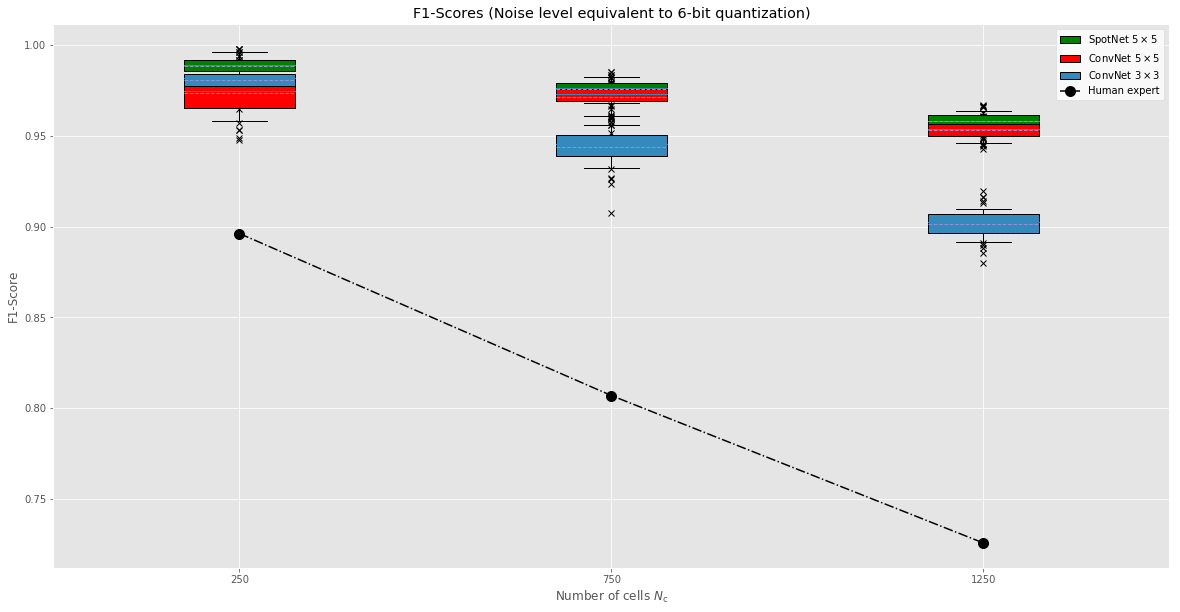

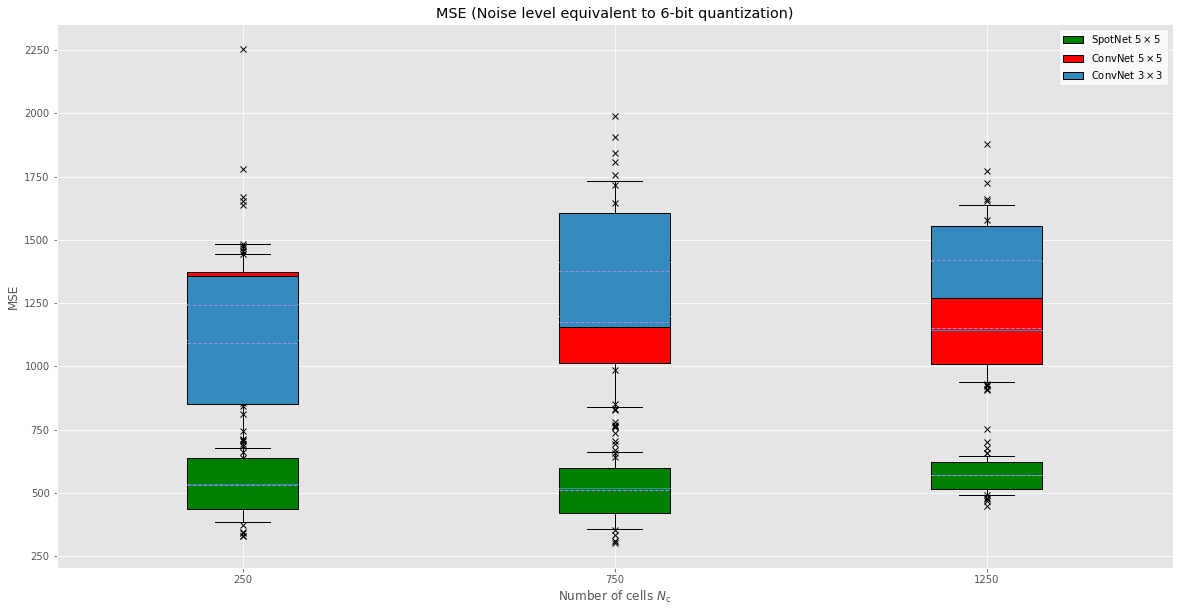

In [6]:
plt.figure( figsize = [20, 10] )
# Boxplot for SpotNet with 5x5 kernels
ax_boxplot_spotnet_5 = plt.boxplot( f1_scores[:,:,0], labels = [250, 750, 1250], whis = [10, 90], showmeans = True, meanline = True, sym = 'x', patch_artist = True );
for index in range(3):
    ax_boxplot_spotnet_5['boxes'][index].set_facecolor('green')
# Boxplot for ConvNet with 5x5 kernels
ax_boxplot_convnet_5 = plt.boxplot( f1_scores[:,:,1], labels = [250, 750, 1250], whis = [10, 90], showmeans = True, meanline = True, sym = 'x', patch_artist = True );
for index in range(3):
    ax_boxplot_convnet_5['boxes'][index].set_facecolor('red')
# Boxplot for ConvNet with 3x3 kernels
ax_boxplot_convnet_3 = plt.boxplot( f1_scores[:,:,2], labels = [250, 750, 1250], whis = [10, 90], showmeans = True, meanline = True, sym = 'x', patch_artist = True );
# Line for human expert
ax_human = plt.plot( np.array([1,2,3]), np.transpose(f1_scores_christian), 'ko-.', ms = 10 )
# Legend 
plt.legend( (ax_boxplot_spotnet_5['boxes'][0], ax_boxplot_convnet_5['boxes'][0], 
             ax_boxplot_convnet_3['boxes'][0], ax_human[0]), 
            (r"SpotNet $5\times 5$", r"ConvNet $5\times 5$", r"ConvNet $3\times 3$", 'Human expert'),
            facecolor = 'white'  )
# Title and axis labels
plt.title( "F1-Scores (Noise level equivalent to 6-bit quantization)" ); 
plt.xlabel( r"Number of cells $N_\mathrm{c}$" ); plt.ylabel( "F1-Score" );

plt.figure( figsize = [20, 10] )
# Boxplot for SpotNet with 5x5 kernels
ax_boxplot_spotnet_5 = plt.boxplot( MSE[:,:,0], labels = [250, 750, 1250], whis = [10, 90], showmeans = True, meanline = True, sym = 'x', patch_artist = True );
for index in range(3):
    ax_boxplot_spotnet_5['boxes'][index].set_facecolor('green')
# Boxplot for ConvNet with 5x5 kernels
ax_boxplot_convnet_5 = plt.boxplot( MSE[:,:,1], labels = [250, 750, 1250], whis = [10, 90], showmeans = True, meanline = True, sym = 'x', patch_artist = True );
for index in range(3):
    ax_boxplot_convnet_5['boxes'][index].set_facecolor('red')
# Boxplot for ConvNet with 3x3 kernels
ax_boxplot_convnet_3 = plt.boxplot( MSE[:,:,2], labels = [250, 750, 1250], whis = [10, 90], showmeans = True, meanline = True, sym = 'x', patch_artist = True );
# Legend 
plt.legend( (ax_boxplot_spotnet_5['boxes'][0], ax_boxplot_convnet_5['boxes'][0], 
             ax_boxplot_convnet_3['boxes'][0]), 
            (r"SpotNet $5\times 5$", r"ConvNet $5\times 5$", r"ConvNet $3\times 3$"),
            facecolor = 'white'  )
# Title and axis labels
plt.title( "MSE (Noise level equivalent to 6-bit quantization)" ); 
plt.xlabel( r"Number of cells $N_\mathrm{c}$" ); plt.ylabel( "MSE" );

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


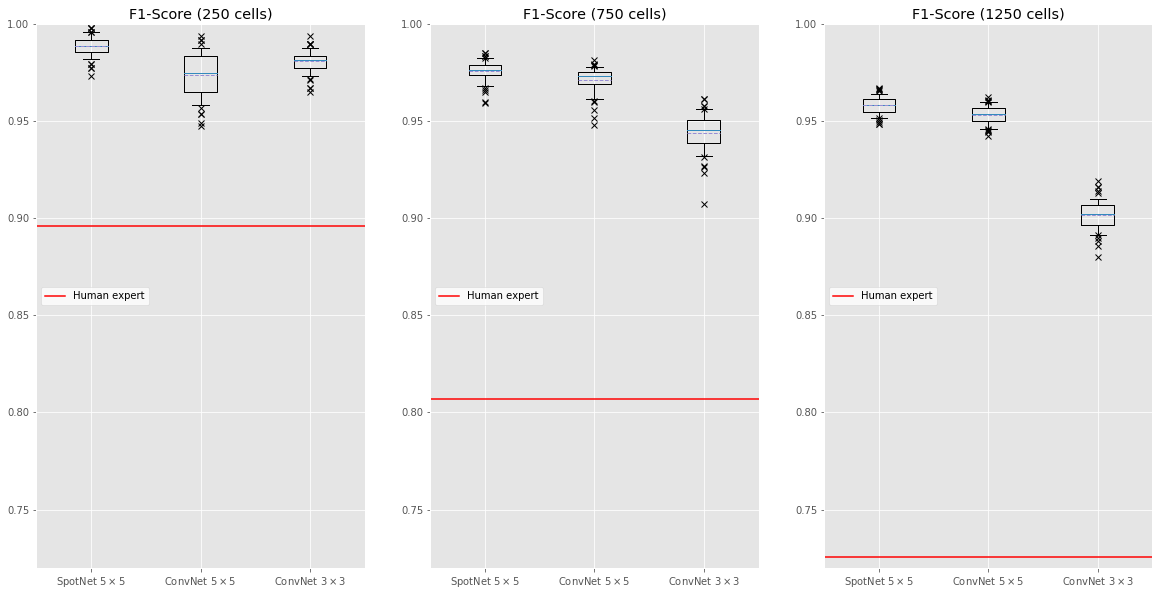

In [23]:
plt.figure( figsize = [20,10] ); ylim = (0.72, 1)
plt.grid( True, which = 'minor' )
# Boxplot for images with 250 cells
plt.subplot( 131 )
plt.boxplot( [f1_scores[:,0,0], f1_scores[:,0,1], f1_scores[:,0,2]], 
             labels = [r"SpotNet $5\times 5$", r"ConvNet $5\times 5$", r"ConvNet $3\times 3$"], 
             whis = [10, 90], showmeans = True, meanline = True, sym = 'x' );
plt.axhline( f1_scores_christian[0,0], color = "red" )
plt.ylim( ylim );
plt.title( 'F1-Score (250 cells)' );
plt.legend( (h,), ('Human expert',), facecolor = 'white', loc = "center left"  );
# Boxplot for images with 750 cells
plt.subplot( 132 )
plt.boxplot( [f1_scores[:,1,0], f1_scores[:,1,1], f1_scores[:,1,2]], 
             labels = [r"SpotNet $5\times 5$", r"ConvNet $5\times 5$", r"ConvNet $3\times 3$"], 
             whis = [10, 90], showmeans = True, meanline = True, sym = 'x' );
plt.axhline( f1_scores_christian[0,1], color = "red" )
plt.title( 'F1-Score (750 cells)' );
plt.ylim( ylim );
plt.legend( (h,), ('Human expert',), facecolor = 'white', loc = "center left"  );
# Boxplot for images with 1250 cells
plt.subplot( 133 )
plt.boxplot( [f1_scores[:,2,0], f1_scores[:,2,1], f1_scores[:,2,2]], 
             labels = [r"SpotNet $5\times 5$", r"ConvNet $5\times 5$", r"ConvNet $3\times 3$"], 
             whis = [10, 90], showmeans = True, meanline = True, sym = 'x' );
h = plt.axhline( f1_scores_christian[0,2], color = "red" )
plt.title( 'F1-Score (1250 cells)' );
plt.ylim( ylim );
plt.legend( (h,), ('Human expert',), facecolor = 'white', loc = "center left" );

plt2tikz.save('../../paper/figs/detection_results.tex');

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


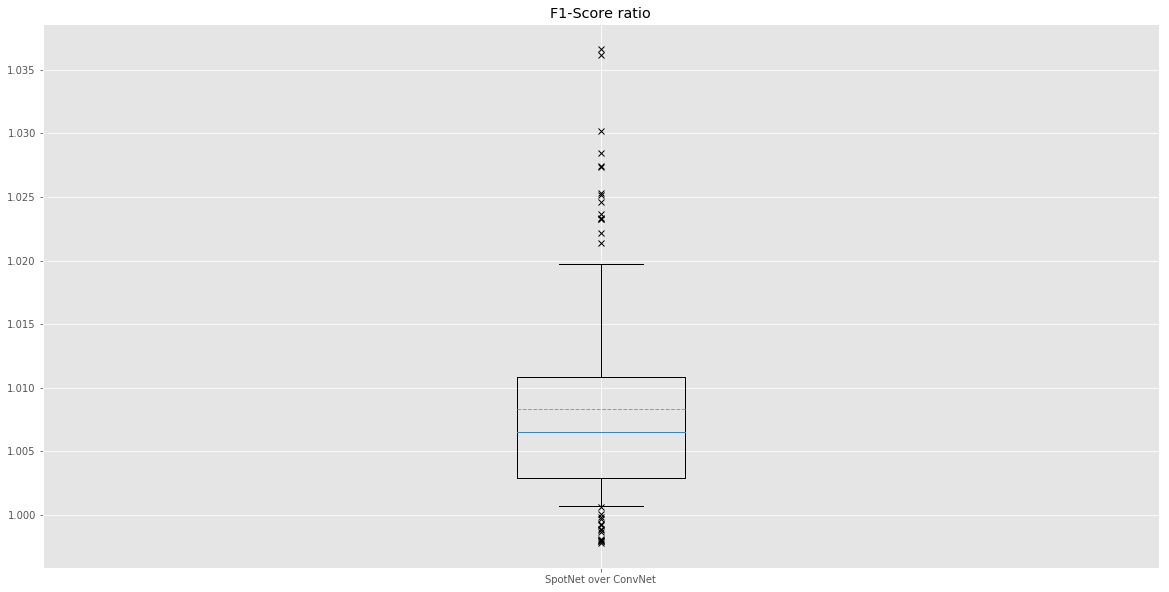

In [36]:
plt.figure( figsize = [20,10] );
plt.grid( True, which = 'minor' )
# Boxplot for 150 test images
plt.boxplot( np.concatenate((f1_scores[:,0,0],f1_scores[:,1,0],f1_scores[:,2,0])) / 
             np.concatenate((f1_scores[:,0,1],f1_scores[:,1,1],f1_scores[:,2,1])), 
             labels = [r"SpotNet over ConvNet"], 
             whis = [10, 90], showmeans = True, meanline = True, sym = 'x' );
#plt.ylim( ylim );
plt.title( 'F1-Score ratio' );
plt2tikz.save('../../paper/figs/detection_comparison.tex');

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


1.9717358723193714

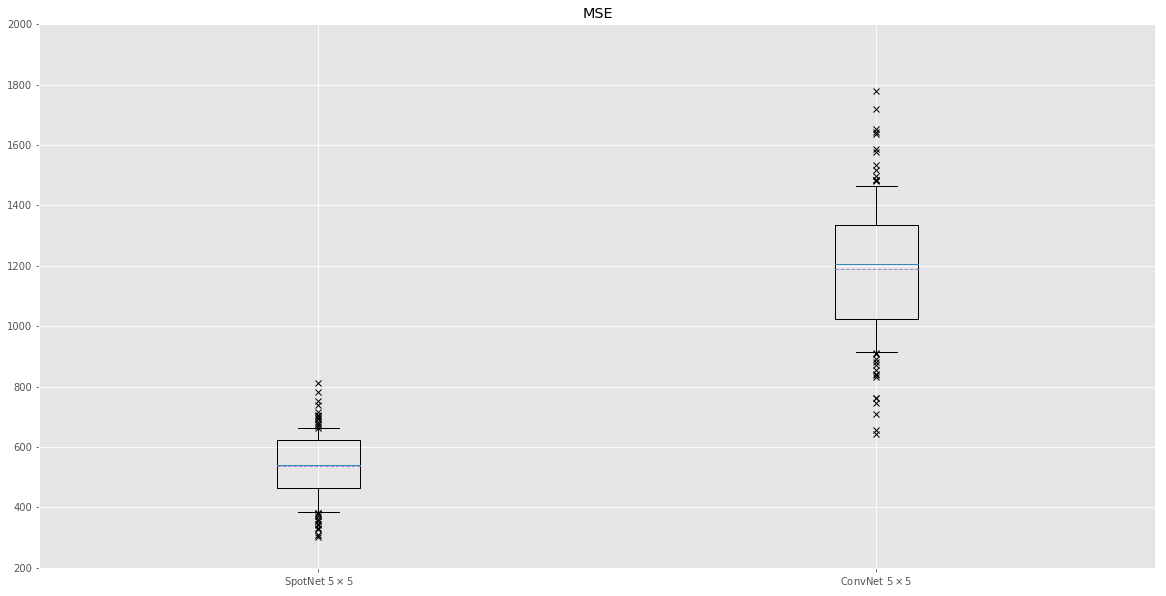

In [33]:
plt.figure( figsize = [20,10] ); ylim = (200, 2000)
plt.grid( True, which = 'minor' )
# Boxplot for 150 test images
plt.boxplot( [np.concatenate((MSE[:,0,0],MSE[:,1,0],MSE[:,2,0])), np.concatenate((MSE[:,0,1],MSE[:,1,1],MSE[:,2,1]))], 
             labels = [r"SpotNet $5\times 5$", r"ConvNet $5\times 5$"], 
             whis = [10, 90], showmeans = True, meanline = True, sym = 'x' );
plt.ylim( ylim );
plt.title( 'MSE' );

plt2tikz.save('../../paper/figs/MSE_results.tex');
(
    ( np.percentile(np.concatenate((MSE[:,0,1],MSE[:,1,1],MSE[:,2,1])),75) 
     - np.percentile(np.concatenate((MSE[:,0,1],MSE[:,1,1],MSE[:,2,1])),25) ) /
    ( np.percentile(np.concatenate((MSE[:,0,0],MSE[:,1,0],MSE[:,2,0])),75)
     - np.percentile(np.concatenate((MSE[:,0,0],MSE[:,1,0],MSE[:,2,0])),25)) 
)


In [14]:
np.concatenate?

TP: 1164, FP: 20, FN: 82, prec: 0.9831, rec: 0.9342, F1: 0.9580, threshold: 66.5932
TP: 1147, FP: 8, FN: 99, prec: 0.9931, rec: 0.9205, F1: 0.9554, threshold: 19.4146
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


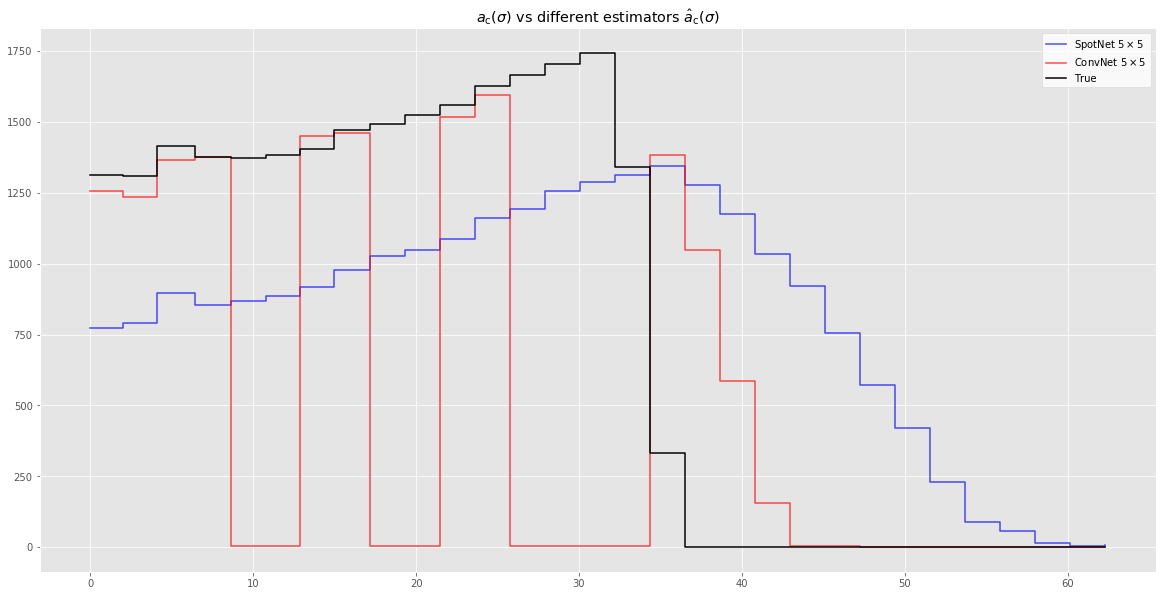

In [36]:
image = np.expand_dims( data['fluorospot'][image_number,...], axis = 0 )
true_psdr = data['psdrs'][image_number,...]
mean_true_psdr = np.mean( true_psdr , axis = 2 )
(x_target, y_target) = np.nonzero( mean_true_psdr )
estimated_psdr_spotnet = predicts_for_eval[0]( {'image': image} )['psdr']
estimated_psdr_convnet = predicts_for_eval[1]( {'image': image} )['psdr']
_, x_out_spotnet, y_out_spotnet, correct_spotnet = optimal_f1_score( np.mean( estimated_psdr_spotnet[0], 2 ), x_target, y_target, verbose = 2 )
_, x_out_convnet, y_out_convnet, correct_convnet = optimal_f1_score( np.mean( estimated_psdr_convnet[0], 2 ), x_target, y_target, verbose = 2 )
pos_out_spotnet = np.transpose(np.array([x_out_spotnet[correct_spotnet>0], y_out_spotnet[correct_spotnet>0]]))
pos_out_convnet = np.transpose(np.array([x_out_convnet[correct_convnet>0], y_out_convnet[correct_convnet>0]]))

# Find first common correct point
agreement = 0; index_spotnet = -1
while agreement == 0:
    index_spotnet += 1
    index_convnet = np.argwhere( np.all( pos_out_convnet - pos_out_spotnet[index_spotnet,:] == 0, axis=1 ) )
    agreement = index_convnet.size
x = pos_out_spotnet[index_spotnet,0]; y = pos_out_spotnet[index_spotnet,1]

sigma_lims = np.array(
                     [ 0.        ,  2.03803742,  4.07607485,  6.44484021,  8.64666049,
                       10.78428037, 12.88968043, 14.97645529, 17.17280857, 19.33452064,
                       21.47205663, 23.59198881, 25.77936086, 27.94416127, 30.09126194,
                       32.22420107, 34.34561714, 36.5144422 , 38.66904129, 40.8116676 ,
                       42.94411325, 45.1138815 , 47.27192547, 49.41978111, 51.55872171,
                       53.68981279, 55.8511504 , 58.00356193, 60.14800566, 62.28530458,
                       64.44840214 ] )
plt.figure( figsize = [20, 10] )
plt.step( sigma_lims[:-1], estimated_psdr_spotnet[0,x,y,:], where = 'post', color = 'blue', alpha = 0.7 )
plt.step( sigma_lims[:-1], estimated_psdr_convnet[0,x,y,:], where = 'post', color = 'red', alpha = 0.7 )
plt.step( sigma_lims[:-1], true_psdr[x,y,:], where = 'post', color = 'black' )
plt.title( r"$a_\mathrm{c}(\sigma)$ vs different estimators $\hat{a}_\mathrm{c}(\sigma)$" );
plt.legend( (r"SpotNet $5\times 5$", r"ConvNet $5\times 5$", "True"), facecolor = 'white' );

plt2tikz.save('../../paper/figs/recovery_vs_sigma.tex');

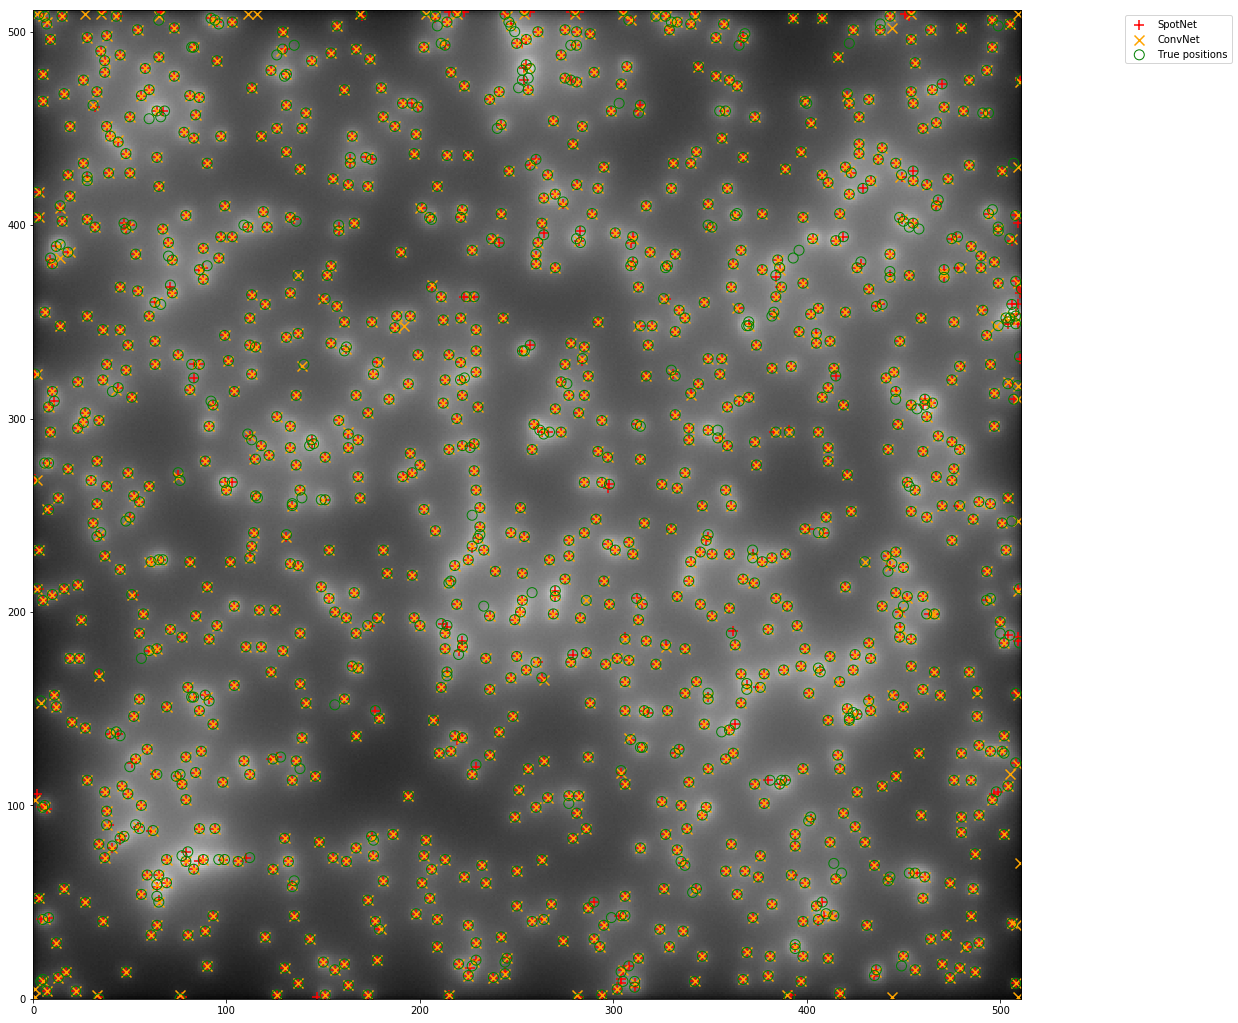

In [8]:
# Plot the Mean PSDRs
plt.figure( figsize = [40, 40] )

ax1 = plt.subplot( 211 )
plt.imshow( image[0,...], cmap = 'gray' )
out_spotnet = plt.scatter( y_out_spotnet, x_out_spotnet, s = 100, marker = '+', edgecolors = 'r', facecolors = 'r')
out_convnet = plt.scatter( y_out_convnet, x_out_convnet, s = 100, marker = 'x', edgecolors = 'orange', facecolors = 'orange')
tar = plt.scatter( y_target, x_target, s = 100, marker = 'o', edgecolors = 'g', facecolors = 'none')
    
plt.legend( (out_spotnet, out_convnet, tar), ('SpotNet', 'ConvNet', 'True positions'), bbox_to_anchor=(1.1,1) );
ax1.set_xlim( [0, 511] ); ax1.set_ylim( [0, 511] );

In [61]:
sigma_lims = np.array(
                     [ 0.        ,  2.03803742,  4.07607485,  6.44484021,  8.64666049,
                       10.78428037, 12.88968043, 14.97645529, 17.17280857, 19.33452064,
                       21.47205663, 23.59198881, 25.77936086, 27.94416127, 30.09126194,
                       32.22420107, 34.34561714, 36.5144422 , 38.66904129, 40.8116676 ,
                       42.94411325, 45.1138815 , 47.27192547, 49.41978111, 51.55872171,
                       53.68981279, 55.8511504 , 58.00356193, 60.14800566, 62.28530458,
                       64.44840214 ] )
which_indices = [5,10,15,20,25,30]
(np.array(which_indices),(.5*(sigma_lims[0:-1] + sigma_lims[1:]))[np.array(which_indices)-1])


(array([ 5, 10, 15, 20, 25, 30]),
 array([ 9.71547043, 20.40328864, 31.15773151, 41.87789043, 52.62426725,
        63.36685336]))